# Implementing a Convolutional Neural Network for Image Classification with PyTorch Using EuroSAT Data
**Content Creator: Azad Rasul**


In this article, we will implement a Convolutional Neural Network (CNN) for image classification using the EuroSAT dataset and PyTorch. EuroSAT is a dataset based on Sentinel-2 satellite images and consists of 10 classes representing different land use and land cover types.

## Importing Libraries

First, let's import the necessary libraries. These include standard Python libraries for file handling, data manipulation, and visualization, as well as libraries specific to deep learning.


In [2]:
# Importing Standard Libraries
import os  # For operating system-related tasks, such as file and directory management
import random  # For generating random numbers, useful for creating randomized datasets
from tqdm.notebook import tqdm  # For displaying progress bars in Jupyter Notebooks

# Data manipulation and visualization
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations in Python
from PIL import Image  # For opening, manipulating, and saving many different image file formats
import seaborn as sns  # For making statistical graphics in Python
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations and handling arrays

# Deep Learning libraries
import torch  # The main PyTorch library for building and training neural networks
import torchvision  # A PyTorch library containing popular datasets, model architectures, and image transformations
import torchsummary  # For printing a summary of the model architecture
from torch.utils.data import Dataset, DataLoader, Subset  # For creating custom datasets and data loaders
from torchvision import datasets, models, transforms  # For dataset handling, model architectures, and image transformations
from sklearn.metrics import confusion_matrix, accuracy_score  # For evaluating model performance
import itertools  # For creating iterators for efficient looping


## Setting Up the Environment

We will set a seed for reproducibility, check if a GPU is available, and set the device accordingly.


In [3]:
# Set seed for reproducibility
# Setting a seed ensures that the results are consistent and reproducible each time the code is run.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Check if GPU is enabled
# PyTorch allows for the use of GPU to speed up training. Here we check if a GPU is available and set the device accordingly.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device.type == 'cuda':
    # If a GPU is available, print the name of the GPU
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda:0
GPU: Tesla T4


## Loading the EuroSAT Dataset

We will download and unzip the EuroSAT dataset.


In [4]:
# Download the EuroSAT dataset ZIP file from the specified URL
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip

# Unzip the downloaded dataset into a directory named 'EuroSAT'
!unzip -q EuroSAT.zip -d 'EuroSAT/'

# Remove the ZIP file to save space now that the contents are extracted
!rm EuroSAT.zip

--2024-07-21 04:37:59--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  17.8MB/s    in 6.2s    

2024-07-21 04:38:06 (14.5 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



## Creating a Custom Dataset Class

We'll create a custom `EuroSAT` dataset class to handle the images and their corresponding labels.


In [5]:
class EuroSAT(Dataset):
    # Initialize the EuroSAT dataset class
    def __init__(self, dataset, transform=None):
        """
        Initializes the EuroSAT dataset class.

        Parameters:
        - dataset: The dataset to be used (assumed to be a list or other iterable of (image, label) pairs).
        - transform: An optional transformation function to be applied to the images.
        """
        self.dataset = dataset  # Store the dataset
        self.transform = transform  # Store the optional transformation function

    def __getitem__(self, index):
        """
        Retrieve an item from the dataset.

        Parameters:
        - index: The index of the item to retrieve.

        Returns:
        - image: The image data at the specified index.
        - label: The label associated with the image.
        """
        image, label = self.dataset[index]  # Get the image and label from the dataset at the specified index

        if self.transform:
            image = self.transform(image)  # Apply the transformation if provided

        return image, label  # Return the image and label

    def __len__(self):
        """
        Get the number of items in the dataset.

        Returns:
        - The length of the dataset (number of items).
        """
        return len(self.dataset)  # Return the length of the dataset


Data Transformations

Define transformations for training and testing:


In [7]:
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])


## Preparing the Data

We will load the data, split it into training and testing sets, and create data loaders for efficient data handling.


In [8]:
# Define the directory where the dataset images are stored
data_dir = './EuroSAT/2750/'

# Create an ImageFolder dataset instance for the specified directory
dataset = datasets.ImageFolder(data_dir)

# Extract and print the class names from the dataset
class_names = dataset.classes
print(f"Class names: {class_names}")

# Print the total number of classes in the dataset
print(f"Total number of classes: {len(class_names)}")

# Define the proportion of the dataset to be used for training
train_size = 0.8

# Generate a list of indices for all data points in the dataset
indices = list(range(len(dataset)))

# Calculate the split index for training and testing data
split = int(train_size * len(dataset))

# Shuffle the indices to randomize the dataset split
np.random.shuffle(indices)

# Split the indices into training and testing indices
train_indices, test_indices = indices[:split], indices[split:]

# Create subsets of the dataset for training and testing using the indices
train_data = EuroSAT(Subset(dataset, train_indices), train_transform)
test_data = EuroSAT(Subset(dataset, test_indices), test_transform)

# Define the batch size and the number of workers for data loading
batch_size = 16
num_workers = 2

# Create DataLoader instances for training and testing data
# Shuffle training data to ensure randomness during training
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# Do not shuffle testing data; it's used for evaluation
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)


Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


## Visualizing Sample Images

We'll visualize some sample images from the training set to get an idea of the data.


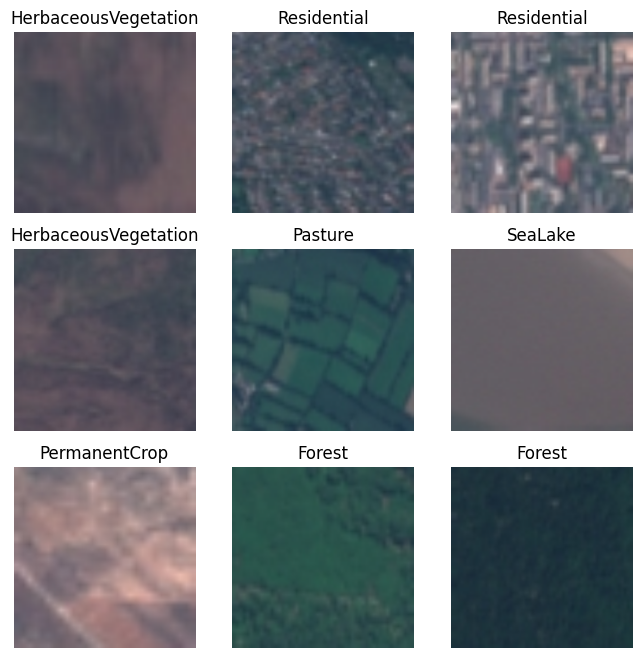

In [9]:
def show_sample_images(dataloader, class_names, n=3):
    """
    Displays a grid of sample images from the dataloader with their corresponding class names.

    Parameters:
    - dataloader: DataLoader object that provides batches of images and labels.
    - class_names: List of class names corresponding to the labels.
    - n: Number of rows and columns in the grid (default is 3 for a 3x3 grid).
    """
    # Get a batch of images and labels from the dataloader
    inputs, classes = next(iter(dataloader))

    # Create a figure with subplots arranged in an n x n grid
    fig, axes = plt.subplots(n, n, figsize=(8, 8))

    # Iterate over each subplot position in the grid
    for i in range(n):
        for j in range(n):
            # Get the image from the batch and convert from CHW to HWC format
            image = inputs[i * n + j].numpy().transpose((1, 2, 0))

            # Reverse the normalization of the image (assuming imagenet_std and imagenet_mean are defined)
            image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

            # Get the class name for the current image
            title = class_names[classes[i * n + j]]

            # Display the image in the current subplot
            axes[i, j].imshow(image)
            axes[i, j].set_title(title)  # Set the title of the subplot to the class name
            axes[i, j].axis('off')  # Hide the axis for a cleaner look

    # Show the plot with the grid of images
    plt.show()

# Call the function to display sample images from the train_loader
show_sample_images(train_loader, class_names)



## Building the Model

We'll use a pre-trained ResNet-50 model and modify the final fully connected layer to match the number of classes in our dataset.


In [10]:
# Load the pre-trained ResNet-50 model
# The 'pretrained=True' argument loads a model that has been pre-trained on ImageNet
model = models.resnet50(pretrained=True)

# Replace the final fully connected layer (classifier) of the model
# model.fc.in_features gives the number of input features to the final layer
# len(class_names) is the number of output classes in our specific task
# We create a new linear layer with the same input features but with an output size equal to the number of classes
model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))

# Move the model to the specified device (CPU or GPU)
# 'device' should be a torch device object (e.g., torch.device('cuda') or torch.device('cpu'))
model = model.to(device)

# Print a summary of the model's architecture
# The summary function shows the model's layers, output shapes, and number of parameters
# (3, 224, 224) indicates the input shape of the images (3 channels, 224x224 pixels)
torchsummary.summary(model, (3, 224, 224))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Defining Loss Function and Optimizer

We'll use Cross-Entropy Loss as our loss function and Stochastic Gradient Descent (SGD) as our optimizer.


In [11]:
# Define the loss function
# CrossEntropyLoss combines LogSoftmax and NLLLoss in one single class.
# It is useful for classification problems.
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer
# SGD stands for Stochastic Gradient Descent. It updates the parameters
# of the model based on the gradients computed during backpropagation.
# Here, we use the parameters of the model and set the learning rate (lr) to 0.001.
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## Training the Model

We will define the training loop.


In [12]:
def train(model, dataloader, criterion, optimizer, device):
    # Set the model to training mode
    model.train()

    # Initialize running totals for loss and correct predictions
    running_loss = 0.0
    running_corrects = 0

    # Loop over data batches in the dataloader
    for inputs, labels in tqdm(dataloader):
        # Move inputs and labels to the specified device (e.g., GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients to avoid accumulation
        optimizer.zero_grad()

        # Forward pass: compute outputs by passing inputs to the model
        outputs = model(inputs)

        # Compute the loss between model outputs and actual labels
        loss = criterion(outputs, labels)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Update model parameters based on the computed gradients
        optimizer.step()

        # Get the predicted class with the highest score
        _, preds = torch.max(outputs, 1)

        # Update the running loss (scaled by the batch size)
        running_loss += loss.item() * inputs.size(0)

        # Update the count of correct predictions
        running_corrects += torch.sum(preds == labels.data)

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    # Return the average loss and accuracy for the epoch
    return epoch_loss, epoch_acc

## Evaluating the Model

We'll define the evaluation loop to test the model on the validation set.

In [13]:
def evaluate(model, dataloader, criterion, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track loss, correct predictions, and store all predictions and labels
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Iterate over the data in the dataloader
        for inputs, labels in tqdm(dataloader):
            # Move inputs and labels to the specified device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Perform forward pass to get outputs from the model
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Get the predicted class by finding the index with the highest score
            _, preds = torch.max(outputs, 1)

            # Update the running loss and correct predictions count
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Store predictions and labels for later use (e.g., for metrics computation)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy over the entire dataset
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    # Return the computed metrics
    return epoch_loss, epoch_acc, all_labels, all_preds

## Training and Validation Loop

We will train the model and validate it after each epoch, saving the best model based on validation loss.


In [15]:
# Initialize the best model weights to the current state of the model
best_model_wts = model.state_dict()

# Set the best loss to infinity initially so that any loss will be lower
best_loss = float('inf')

# Set the number of epochs to train the model
num_epochs = 30

# Loop over the dataset multiple times (each loop is one epoch)
for epoch in range(num_epochs):
    # Print the current epoch number
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train the model and get the training loss and accuracy
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)

    # Print the training loss and accuracy for the current epoch
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

    # Evaluate the model on the validation set and get the loss, accuracy, all labels, and all predictions
    val_loss, val_acc, all_labels, all_preds = evaluate(model, test_loader, criterion, device)

    # Print the validation loss and accuracy for the current epoch
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # If the current validation loss is lower than the best loss seen so far
    if val_loss < best_loss:
        # Update the best loss to the current validation loss
        best_loss = val_loss
        # Save the model weights as the best model weights
        best_model_wts = model.state_dict()

# Load the best model weights into the model
model.load_state_dict(best_model_wts)

# Define the directory where the model will be saved
model_dir = "./drive/My Drive/Colab Notebooks/models/"

# Create the directory if it does not exist
os.makedirs(model_dir, exist_ok=True)

# Define the file path for saving the best model weights
model_file = os.path.join(model_dir, 'best_model.pth')

# Save the best model weights to the file
torch.save(model.state_dict(), model_file)

# Print a message indicating that the model has been saved
print(f'Model saved to {model_file}')


Epoch 1/5


  0%|          | 0/1350 [00:00<?, ?it/s]

Train Loss: 0.2654 Acc: 0.9128


  0%|          | 0/338 [00:00<?, ?it/s]

Val Loss: 0.0927 Acc: 0.9706
Epoch 2/5


  0%|          | 0/1350 [00:00<?, ?it/s]

Train Loss: 0.2525 Acc: 0.9201


  0%|          | 0/338 [00:00<?, ?it/s]

Val Loss: 0.0907 Acc: 0.9713
Epoch 3/5


  0%|          | 0/1350 [00:00<?, ?it/s]

Train Loss: 0.2394 Acc: 0.9223


  0%|          | 0/338 [00:00<?, ?it/s]

Val Loss: 0.0805 Acc: 0.9737
Epoch 4/5


  0%|          | 0/1350 [00:00<?, ?it/s]

Train Loss: 0.2273 Acc: 0.9285


  0%|          | 0/338 [00:00<?, ?it/s]

Val Loss: 0.0706 Acc: 0.9774
Epoch 5/5


  0%|          | 0/1350 [00:00<?, ?it/s]

Train Loss: 0.2107 Acc: 0.9327


  0%|          | 0/338 [00:00<?, ?it/s]

Val Loss: 0.0706 Acc: 0.9770
Model saved to ./drive/My Drive/Colab Notebooks/models/best_model.pth


## Loading the Best Model for Evaluation

We will load the best model saved during training and use it for evaluation.


In [16]:
# Load a pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer to match the number of classes in your dataset
# The original ResNet-50 has 1000 output features for 1000 classes (ImageNet dataset)
# We replace it with a new linear layer that has 'len(class_names)' output features (number of classes in your dataset)
model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))

# Load the trained model weights from a file
# 'model_file' is the path to the file containing the model weights
model.load_state_dict(torch.load(model_file))

# Move the model to the appropriate device (CPU or GPU)
# 'device' is a variable specifying whether to use CPU or GPU (e.g., device = torch.device('cuda') or device = torch.device('cpu'))
model = model.to(device)

# Set the model to evaluation mode
# This is important because it changes the behavior of some layers, like dropout and batch normalization, which should behave differently during training and evaluation
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Plotting the Confusion Matrix

We will calculate and plot the confusion matrix to visualize the performance of our model.

Confusion matrix, without normalization
Overall accuracy: 0.9770


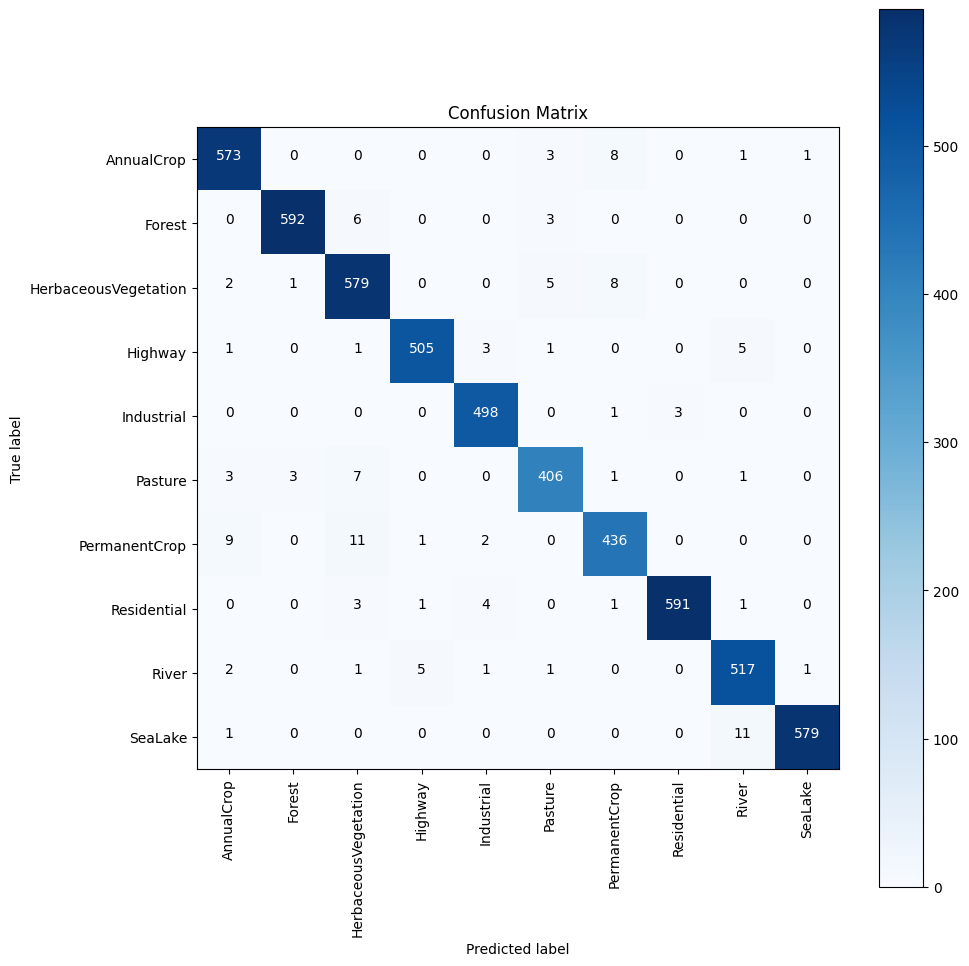

In [17]:
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    # If normalization is set to True, normalize the confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Print a message indicating whether the confusion matrix is normalized or not
    print("Confusion matrix, without normalization" if not normalize else "Normalized confusion matrix")

    # Create a new figure with a specified size
    plt.figure(figsize=(10, 10))
    # Display the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # Set the title of the plot
    plt.title(title)
    # Add a color bar to the side of the plot
    plt.colorbar()
    # Set tick marks at each class index
    tick_marks = np.arange(len(classes))
    # Label the x-axis ticks with the class names, rotated 90 degrees
    plt.xticks(tick_marks, classes, rotation=90)
    # Label the y-axis ticks with the class names
    plt.yticks(tick_marks, classes)

    # Format the values in the confusion matrix as float with 2 decimals if normalized, otherwise as integers
    fmt = '.2f' if normalize else 'd'
    # Determine a threshold to change text color for better readability
    thresh = cm.max() / 2.
    # Iterate through each cell in the confusion matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Place the text in the middle of each cell
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Adjust the layout for better fit
    plt.tight_layout()
    # Label the y-axis as 'True label'
    plt.ylabel('True label')
    # Label the x-axis as 'Predicted label'
    plt.xlabel('Predicted label')

# Calculate and plot the confusion matrix
# `all_labels` contains the true labels and `all_preds` contains the predicted labels
cm = confusion_matrix(all_labels, all_preds)
# `class_names` contains the list of class names
plot_confusion_matrix(cm, class_names, title='Confusion Matrix')

# Calculate the overall accuracy of the model
accuracy = accuracy_score(all_labels, all_preds)
# Print the overall accuracy
print(f'Overall accuracy: {accuracy:.4f}')


## Making Predictions on Sample Images

Finally, we will use our trained model to make predictions on some sample images from the dataset.


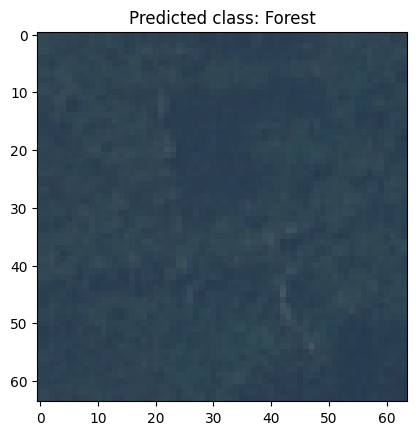

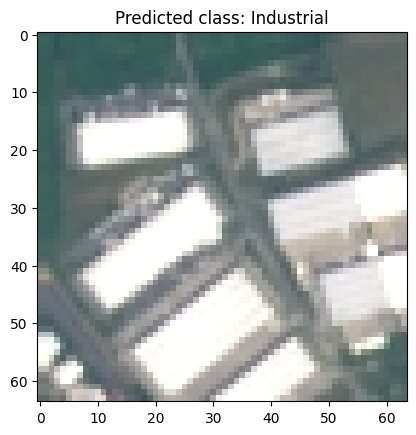

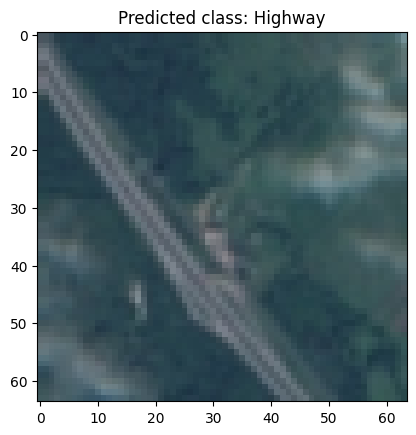

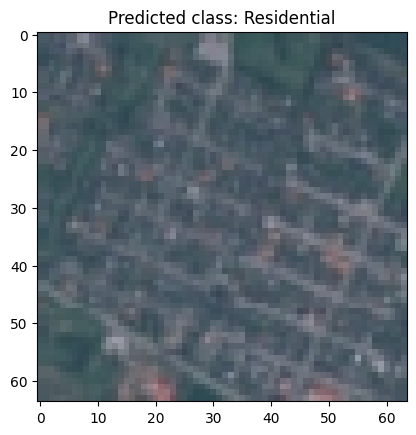

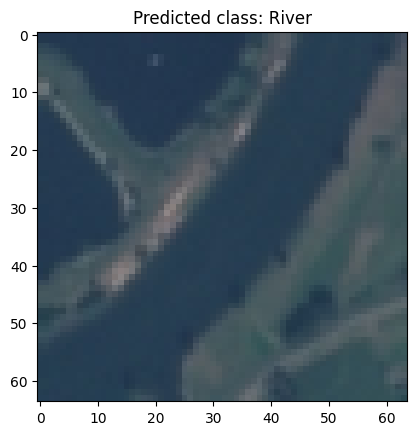

In [18]:
def predict_image(image, model, class_names, device):
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():  # Disable gradient computation for faster inference
        # Move the image to the specified device (CPU or GPU) and make predictions
        outputs = model(image.to(device))
        # Get the predicted class by finding the index with the highest score
        _, preds = torch.max(outputs, 1)
    # Return the name of the predicted class
    return class_names[preds.item()]

# Predict on a single sample image
image_path = './EuroSAT/2750/Forest/Forest_10.jpg'
image = Image.open(image_path)  # Open the image file
input_image = test_transform(image).unsqueeze(0).to(device)  # Apply transformations and add batch dimension
pred_class = predict_image(input_image, model, class_names, device)  # Predict the class of the image

# Display the image along with the predicted class
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_title(f"Predicted class: {pred_class}")
plt.show()

# Predict on multiple sample images
sample_image_paths = [
    './EuroSAT/2750/Industrial/Industrial_10.jpg',
    './EuroSAT/2750/Highway/Highway_10.jpg',
    './EuroSAT/2750/Residential/Residential_10.jpg',
    './EuroSAT/2750/River/River_10.jpg'
]

for image_path in sample_image_paths:
    image = Image.open(image_path)  # Open the image file
    input_image = test_transform(image).unsqueeze(0).to(device)  # Apply transformations and add batch dimension
    pred_class = predict_image(input_image, model, class_names, device)  # Predict the class of the image

    # Display the image along with the predicted class
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title(f"Predicted class: {pred_class}")
    plt.show()


## Conclusion

In this tutorial, we successfully implemented a Convolutional Neural Network (CNN) for image classification using the EuroSAT dataset and PyTorch. We went through the steps of loading the data, preprocessing it, building the model, training and evaluating it, and making predictions on sample images. This workflow can be adapted to other image classification tasks with different datasets.


**References**

*   Helber, P., Bischke, B., Dengel, A., & Borth, D. (2018). Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. arXiv preprint arXiv:1709.00029. Available at: https://arxiv.org/abs/1709.00029
*   Reid Falconer, Land Use and Land Cover Classification (Beating the Benchmark). Available at: https://github.com/reidfalconer/landcover_classification
*   Ankur Mahesh & Isabelle Tingzon, Land Use and Land Cover Classification using PyTorch. Available at: https://colab.research.google.com/drive/1Wj0LsIuotZssoQUw0QUryWk9WbOFIzV8?usp=sharing



